In [52]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [53]:
from pickle import load
from pickle import dump
from myTools import *
import datetime
import joblib

from lightgbm import LGBMClassifier

from A_Data_Preparation import prepareData

### Algorithme optimisé à l'étape 4

In [55]:
model = LGBMClassifier(max_depth=7, 
                       learning_rate=0.125, 
                       num_leaves=8, 
                       min_child_samples=300, 
                       subsample_for_bin=25000, 
                       n_estimators=300, 
                       n_jobs=-1)

### Préparation des données

#### Constitution du dataframe

In [4]:
dfApplication = prepareData('train')

2021-07-11 09:15:30.027649
2021-07-11 09:16:14.875396 - 44.84774470329285 - fichiers chargés
2021-07-11 09:17:43.805751 - 88.93035507202148 - marquage des valeurs manquantes
2021-07-11 09:17:43.806413 - 0.00066375732421875 - suppression de variables et renommage de colonnes
2021-07-11 09:18:53.811888 - 70.00547170639038 - mise à plat
2021-07-11 09:19:04.641728 - 10.829840660095215 - suppression de colonnes
2021-07-11 09:19:04.879533 - 0.2378063201904297 - missing default
2021-07-11 09:19:04.879836
2021-07-11 09:19:37.960969 - 33.081130266189575 - fichiers chargés
2021-07-11 09:21:07.065360 - 89.10438919067383 - marquage des valeurs manquantes
2021-07-11 09:21:08.299287 - 1.2339277267456055 - suppression de lignes
2021-07-11 09:21:08.311317 - 0.012029170989990234 - feature engineering sur REQ
2021-07-11 09:21:11.268961 - 2.9576454162597656 - feature engineering sur days_employed
2021-07-11 09:21:11.918529 - 0.6495676040649414 - feature engineering sur FAMILY_STATUS
2021-07-11 09:22:06.3

In [56]:
dfApplication = load(open('dfApplicationTrain.pkl','rb'))

In [57]:
dfApplication.shape

(289444, 230)

#### Suppression des variables à importance nulle

In [58]:
def imputeScaleAndEncode(df1, 
                    target='', 
                    identifier=''):
    
    df = df1.copy()
    
    if type(target) == str:
        target = [target]
    if type(identifier) == str:
        identifier = [identifier]
    
    colToExclude = target
    colToExclude.extend(identifier)
    
    for col in df.columns:
        if col not in colToExclude:
            if df[col].dtypes == 'object':
                df[col] = df[col].replace(np.nan, 'missing')
                df[col] = OrdinalEncoder().fit_transform(df[[col]])
            elif df[col].dtype in ['int64','float64']:
                df[col] = SimpleImputer(strategy='mean').fit_transform(df[[col]])
                df[col] = MinMaxScaler().fit_transform(df[[col]])  
                
    return df


#### On ordonne les variables selon leur importance

In [59]:
imp = featureImportance(imputeScaleAndEncode(dfApplication, 
                                             target='TARGET', 
                                             identifier='SK_ID_CURR'), 
                        target='TARGET', 
                        identifier='SK_ID_CURR', 
                        model=model)
imp = imp[imp.impMean > 0]
imp = imp[['feature','impMean']]

In [60]:
cols = ['SK_ID_CURR','TARGET']
cols.extend(list(imp.feature))
dfApplication = dfApplication[cols]

### Construction du pipeline

#### Récupération des transformations de colonnes (voir étape 4)

In [61]:
dictDataTransform = load(open('dictDataTransform.pkl','rb'))
power = dictDataTransform['power']
quantile = dictDataTransform['quantile']
kbins10 = dictDataTransform['kbins10']
kbins50 = dictDataTransform['kbins50']
kbins100 = dictDataTransform['kbins100']
standard = dictDataTransform['standard']
minmax = dictDataTransform['minmax']
robust = dictDataTransform['robust']

In [62]:
pipeline = getPipeline(
                        dfApplication,
                        target='TARGET', 
                        identifier='SK_ID_CURR', 
                        defaultCatImputer = SimpleImputer(strategy='most_frequent'),
                        defaultOrdImputer = SimpleImputer(strategy='most_frequent'),
                        defaultNumImputer = SimpleImputer(strategy='mean'),                                            
                        power=power, quantile=quantile, kbins10=kbins10, kbins50=kbins50, kbins100=kbins100,
                        defaultScaler=MinMaxScaler(),
                        minmax=minmax, standard=standard, robust=robust,
                        model=model)

### Entrainement du modèle

In [63]:
dfApplicationSvg = dfApplication.copy()

In [64]:
y = dfApplication['TARGET']
del dfApplication['SK_ID_CURR']
del dfApplication['TARGET']

pipeline.fit(dfApplication,y)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('1',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('trans',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=100,
                                                                                    strategy='uniform')),
                                                                  ('scal',
                                                                   StandardScaler())]),
                                                  ['EXT_SOURCE_3',
                                                   'DAYS_EMPLOYED',
                                                   'POSCASH_CNT_INSTALMENT_FUTURE_D

### Métriques

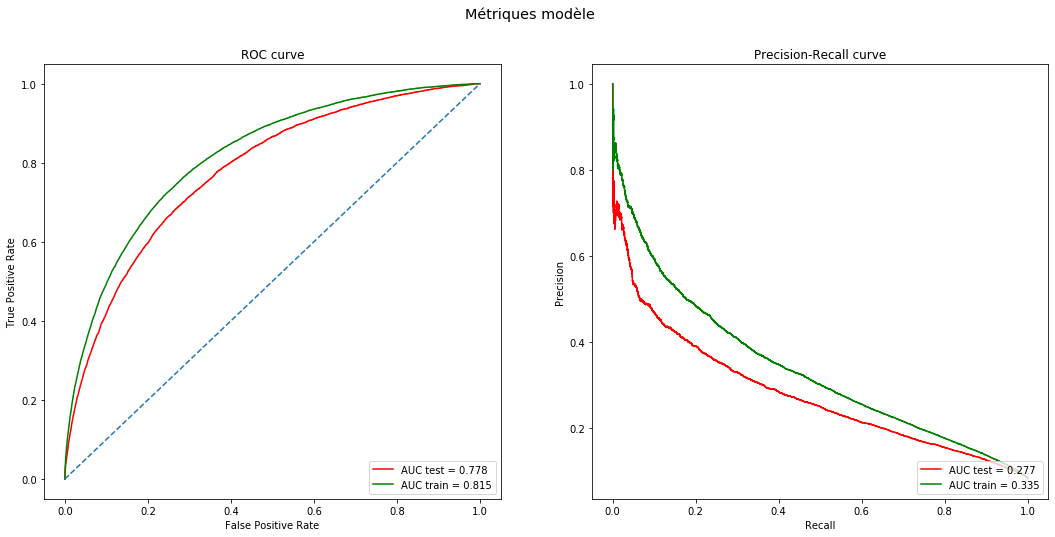

TRAIN SET: ROC AUC=0.815, PR AUC=0.335
TEST SET:  ROC AUC=0.778, PR AUC=0.277


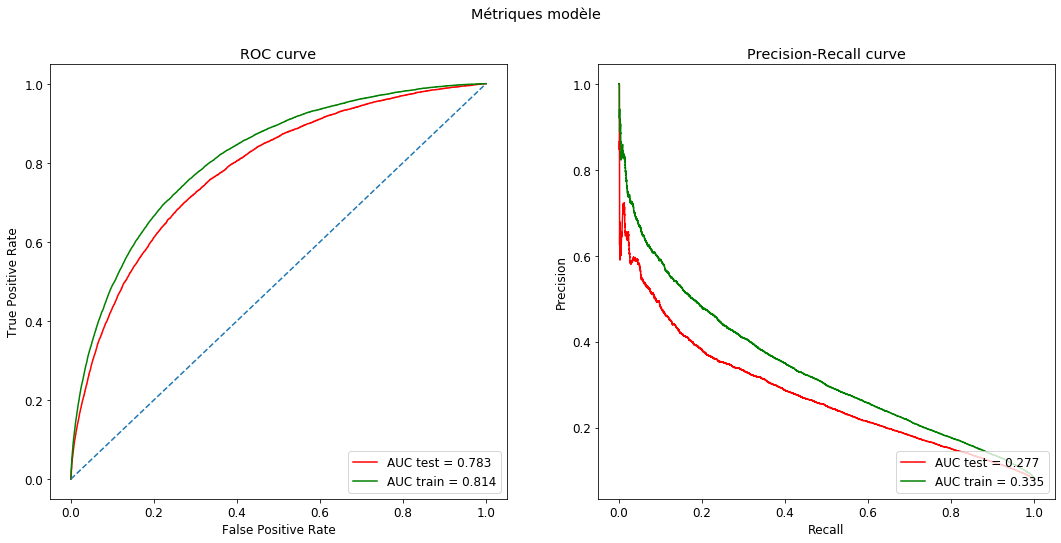

TRAIN SET: ROC AUC=0.814, PR AUC=0.335
TEST SET:  ROC AUC=0.783, PR AUC=0.277


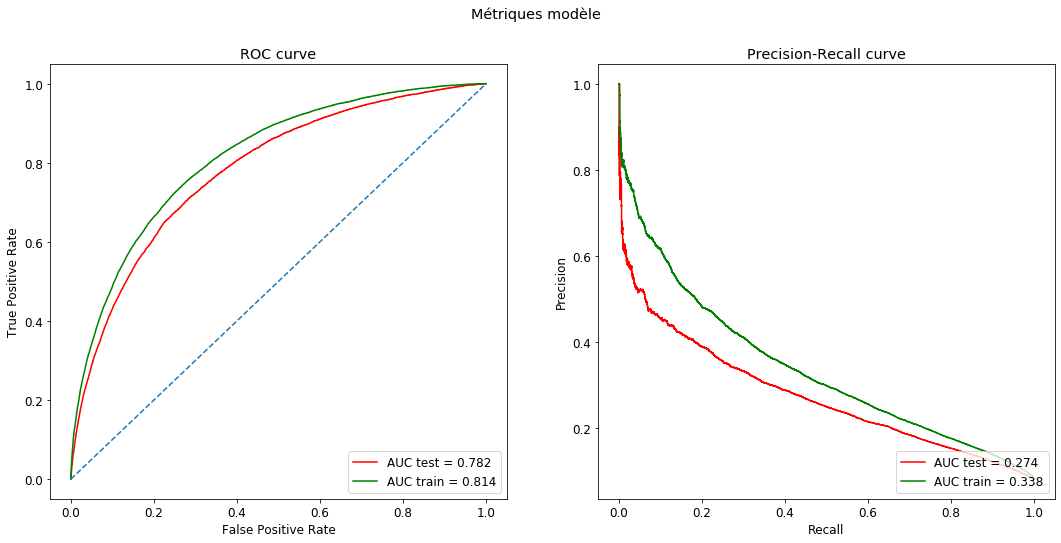

TRAIN SET: ROC AUC=0.814, PR AUC=0.338
TEST SET:  ROC AUC=0.782, PR AUC=0.274

_______________________________________________________________________________________________________________________________________
METRIQUES MOYENNES TEST:
ROC AUC = 0.781
PR AUC  = 0.276
_______________________________________________________________________________________________________________________________________
_______________________________________________________________________________________________________________________________________
METRIQUES MOYENNES TRAIN:
ROC AUC = 0.814
PR AUC  = 0.336
_______________________________________________________________________________________________________________________________________




In [65]:
results_tmp = []

results_tmp.append(evaluateRocPrCurves(dfApplicationSvg, 
                        target='TARGET', 
                        identifier='SK_ID_CURR', 
                        model=model,
                        defaultCatImputer = SimpleImputer(strategy='most_frequent'),
                        defaultOrdImputer = SimpleImputer(strategy='most_frequent'),
                        defaultNumImputer = SimpleImputer(strategy='mean'),                                            
                        power=power, quantile=quantile, kbins10=kbins10, kbins50=kbins50, kbins100=kbins100,
                        defaultScaler=MinMaxScaler(),
                        minmax=minmax, standard=standard, robust=robust,
                        display_plot=True,
                        title_plot = 'Métriques modèle',
                        cv=3))

### Interprétabilité du modèle

#### Feature importance

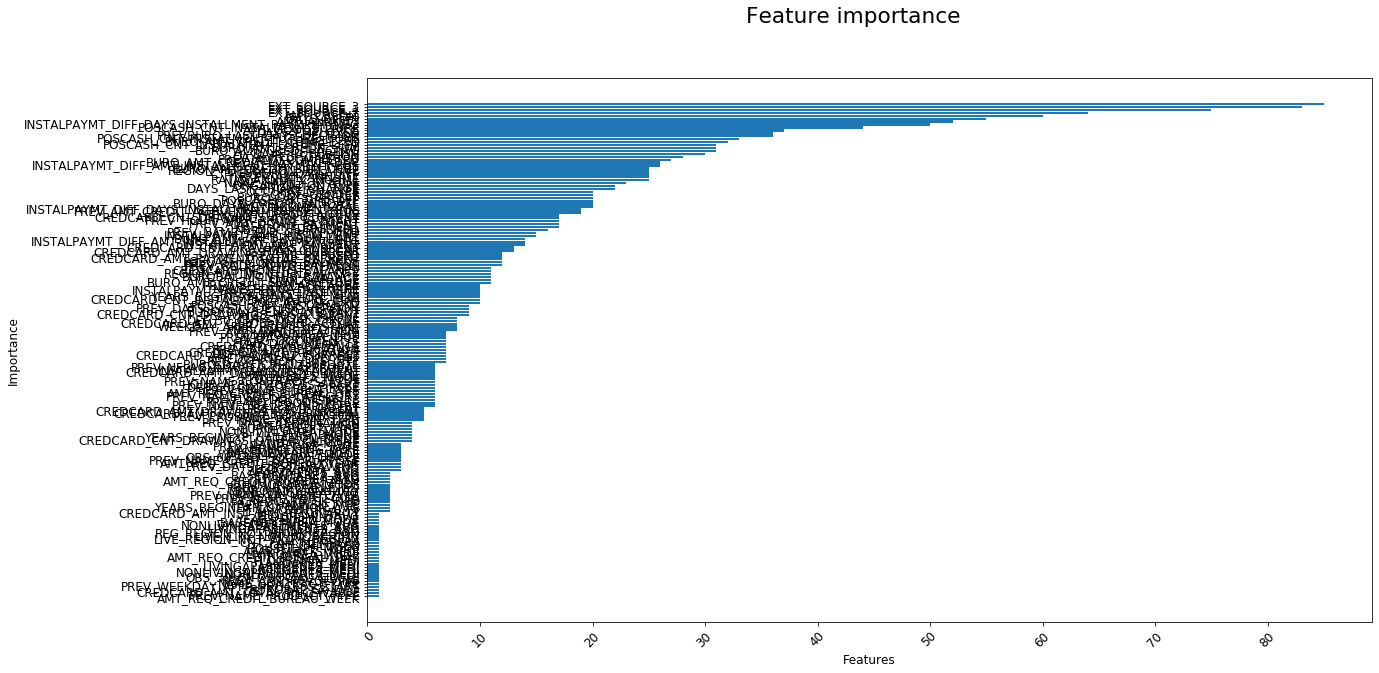

In [66]:
plt.rcParams.update({'font.size':12})

fig = plt.figure(figsize=(18, 10))

impplot = imp.sort_values('impMean', ascending=True)

sub = fig.add_subplot(1,1,1)

plt.rcParams.update({'font.size':10, 'font.style':'normal'})
plt.barh(impplot['feature'], impplot['impMean'])
plt.gca().set_xlabel('Features')
plt.gca().set_ylabel('Importance')


plt.rcParams.update({'font.size':18})
plt.suptitle("Feature importance")

plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

plt.show()

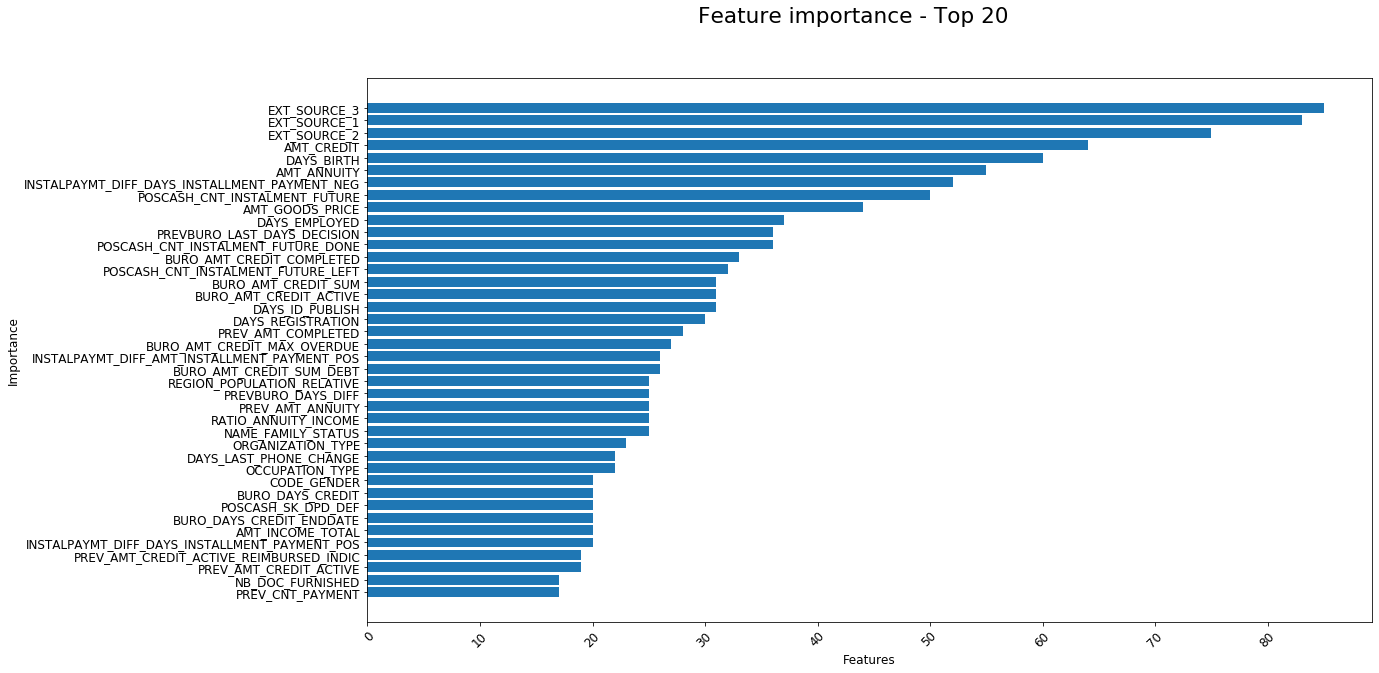

In [67]:
plt.rcParams.update({'font.size':12})

fig = plt.figure(figsize=(18, 10))

impplot = imp[0:40].sort_values('impMean', ascending=True)

sub = fig.add_subplot(1,1,1)

plt.rcParams.update({'font.size':10, 'font.style':'normal'})
plt.barh(impplot['feature'], impplot['impMean'])
plt.gca().set_xlabel('Features')
plt.gca().set_ylabel('Importance')


plt.rcParams.update({'font.size':18})
plt.suptitle("Feature importance - Top 20")

plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

plt.show()

#### Distribution de la classe positive de la target selon les variables (par ordre d'importance des variables)

In [68]:
dfApplication = dfApplicationSvg.copy()

In [69]:
categorical_col = []
ordinal_col = []
numerical_col = []

for col in dfApplication.columns:
    if col not in ['TARGET','SK_ID_CURR']:
        if dfApplication[col].dtypes == 'object':
            categorical_col.append(col)
        else:
            if dfApplication[col].nunique() < 100:
                ordinal_col.append(col)
            else:
                numerical_col.append(col)

In [70]:
dfApplicationSvg = dfApplication.copy()

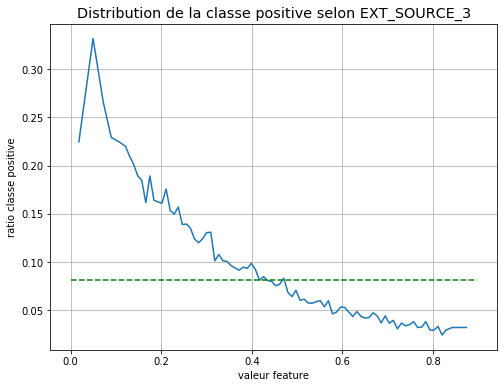

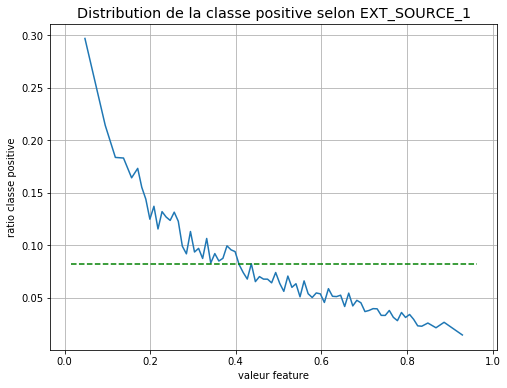

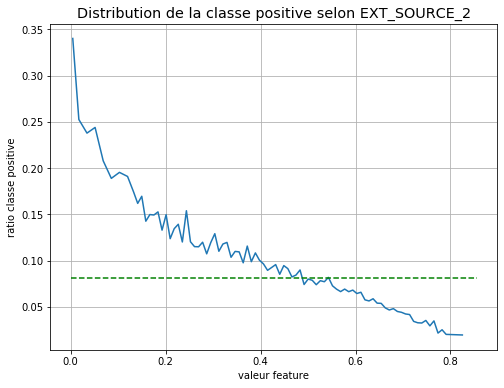

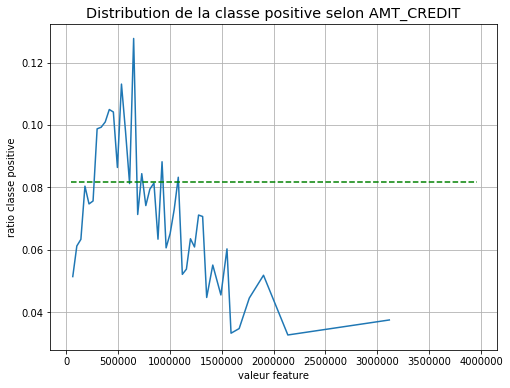

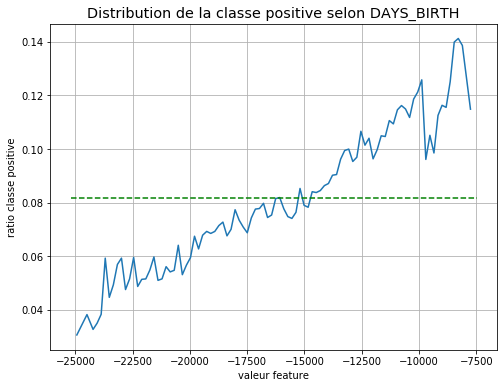

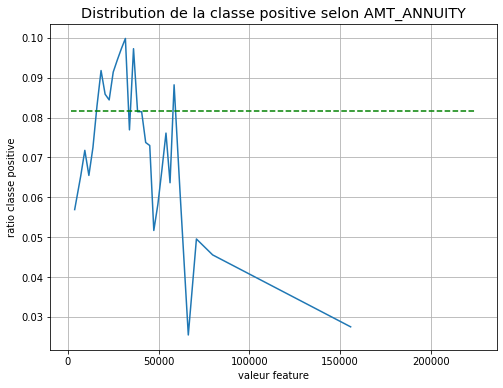

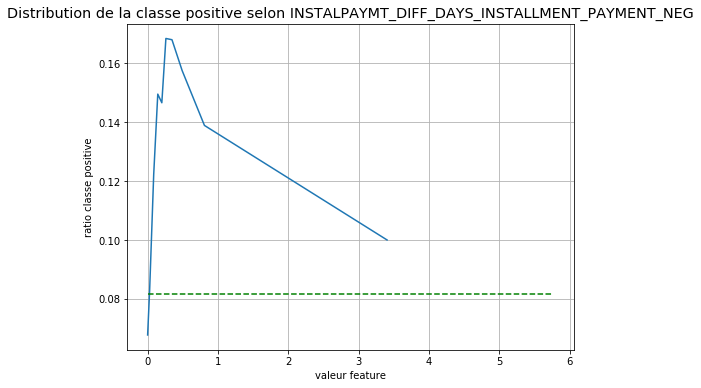

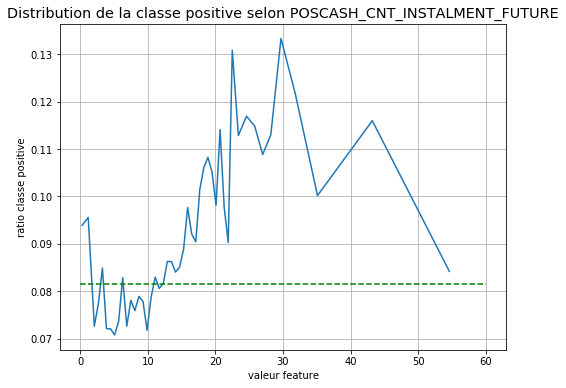

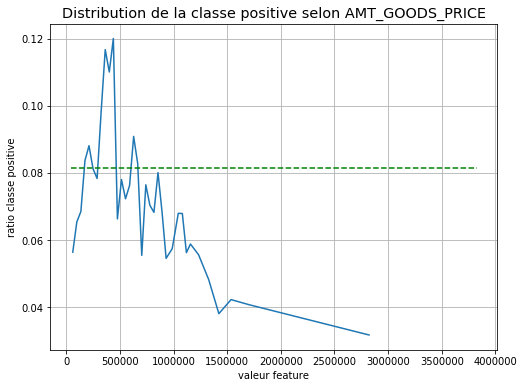

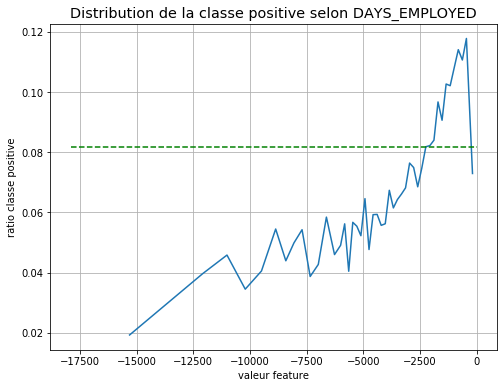

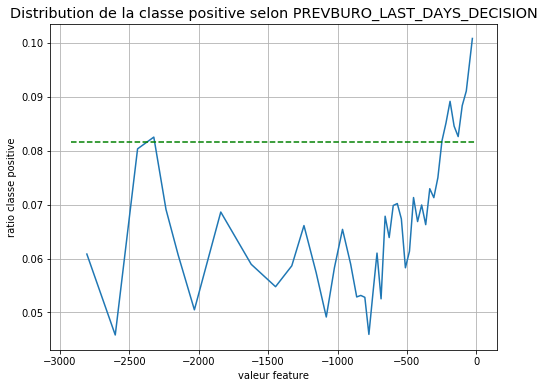

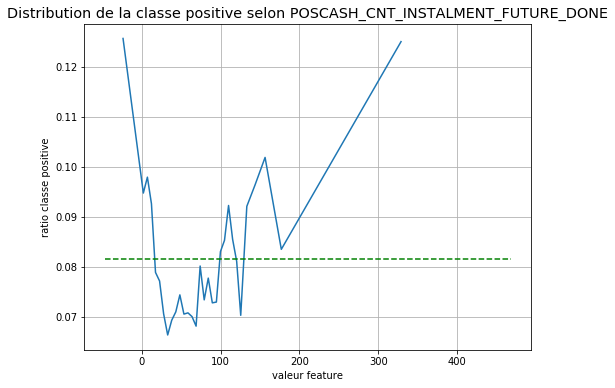

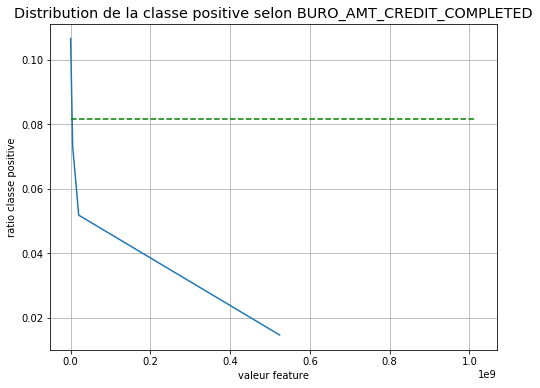

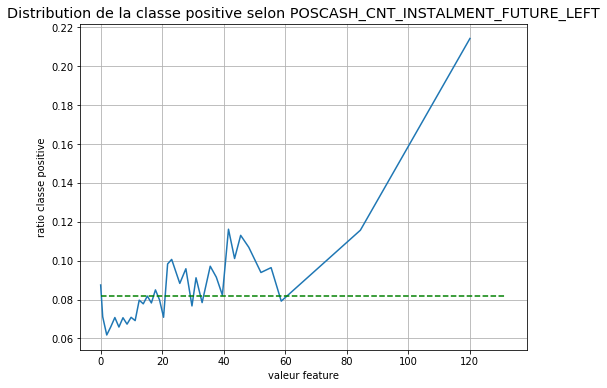

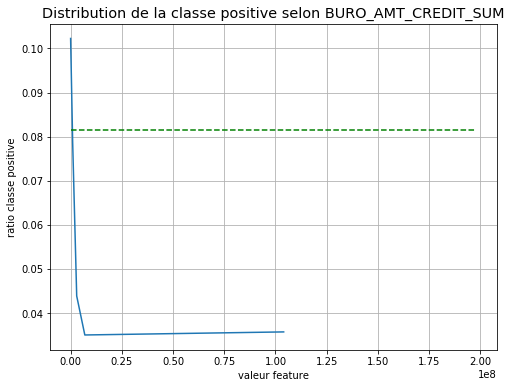

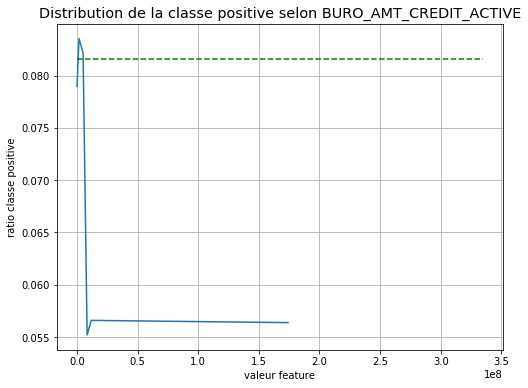

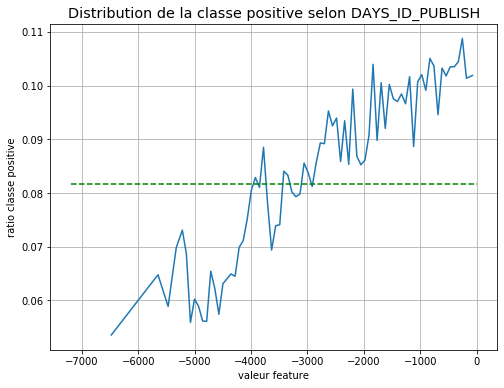

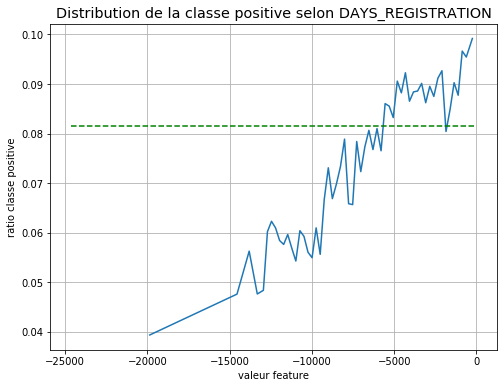

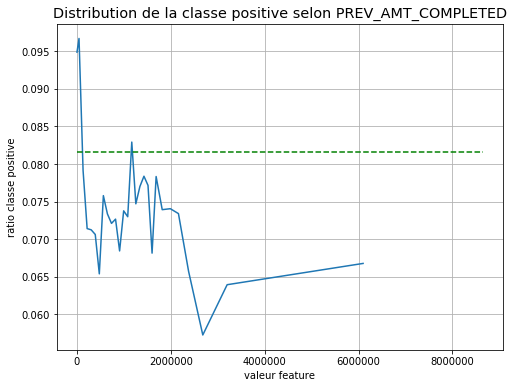

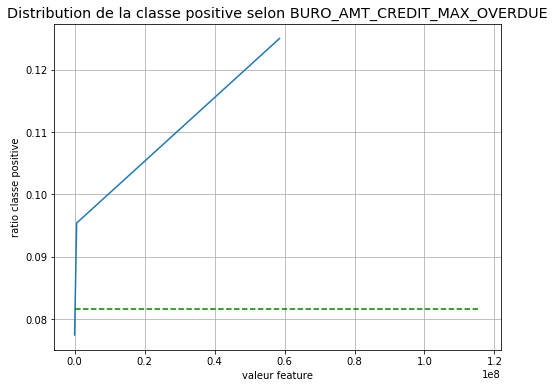

In [71]:
listRatioCat = []
listRatioOrd = []
distribRatioNum = None

dfApplication = dfApplicationSvg.copy()
dfApplication['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG'] = dfApplication.apply(lambda x: np.log(1-x.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG), axis=1)


nb_pos_tot = dfApplication[dfApplication['TARGET'] == 1].shape[0]
nb_tot = dfApplication.shape[0]
ratio_pos = nb_pos_tot / nb_tot


i = 1
for col in imp.feature:

    if col in numerical_col:
        if i <= 20:
            distribImbalanced(dfApplication, col, 'TARGET')
        try:
            distribRatioNum = pd.concat([distribRatioNum,distribRatio(dfApplication, col, 'TARGET', bins=1000)])
        except:
            distribRatioNum = distribRatio(dfApplication, col, 'TARGET', bins=1000)
    else:
        listRatioTmp = []
        for val in dfApplication[col].unique():
            counter = Counter(dfApplication[dfApplication[col] == val].TARGET)
            for k,v in counter.items():
                if k == 1:
                    nb = len(dfApplication[dfApplication[col] == val].TARGET)
                    per = v / nb
                    listRatioTmp.append([val,per])        
                    if col in categorical_col:
                        listRatioCat.append([col,val,nb,per])
                    if col in ordinal_col:
                        listRatioOrd.append([col,val,nb,per])
        if i <= 20:
            x = list(np.array(listRatioTmp).T[0])
            y = [np.float(x) for x in list(np.array(listRatioTmp).T[1])]
            fig = plt.figure(figsize=(15,8))
            plt.title('Distribution de la classe positive selon ' + col)
            plt.ylabel('ratio classe positive')
            plt.xlabel('valeur feature')
            plt.bar(x,y)
            plt.axhline(y=ratio_pos,ls='--')
            plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
        
        plt.show()
    
    i += 1

#### Statisques univariée des 20 variables les plus importantes

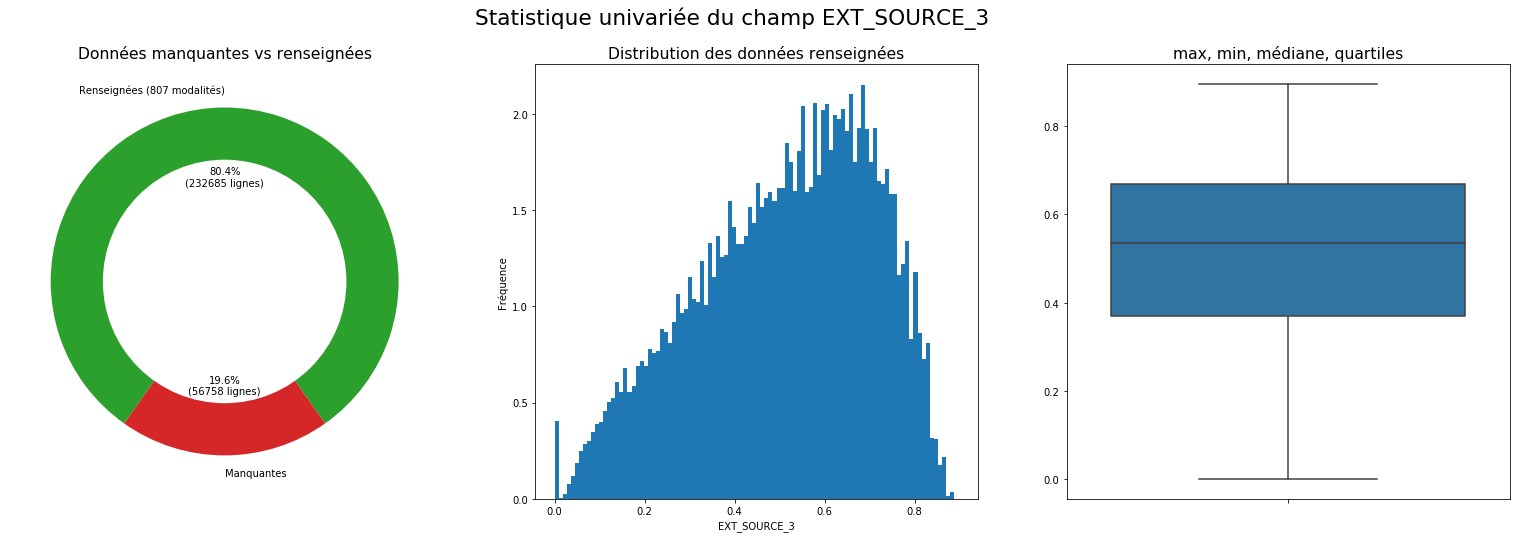

Mesures de position
 - Moyenne: 0.51088
 - Médiane: 0.53528
Mesures de dispertion
 - Ecart type: 0.19472
 - Min: 0.00053
 - Q25: 0.37065
 - Q75: 0.66906
 - Max: 0.89601
Mesures de forme
 - Skewness (asymétrie): -0.41
 - Kurtosis (applatissement): -0.663


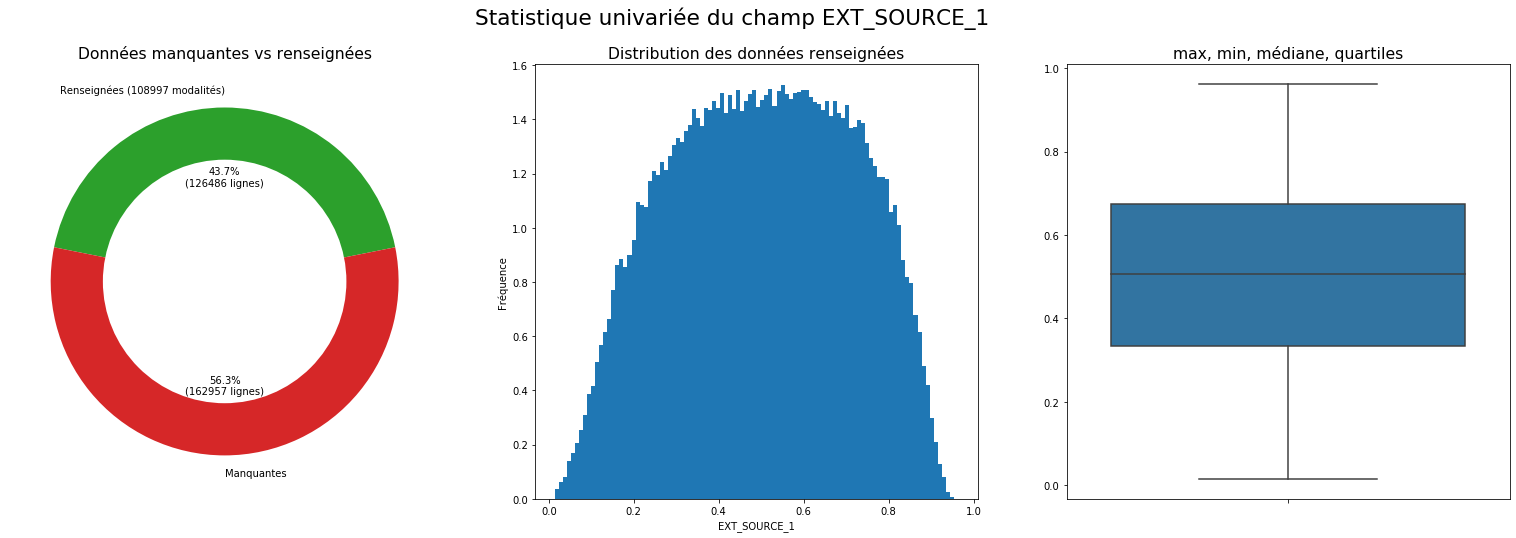

Mesures de position
 - Moyenne: 0.50167
 - Médiane: 0.50551
Mesures de dispertion
 - Ecart type: 0.21095
 - Min: 0.01457
 - Q25: 0.33362
 - Q75: 0.67434
 - Max: 0.96269
Mesures de forme
 - Skewness (asymétrie): -0.067
 - Kurtosis (applatissement): -0.965


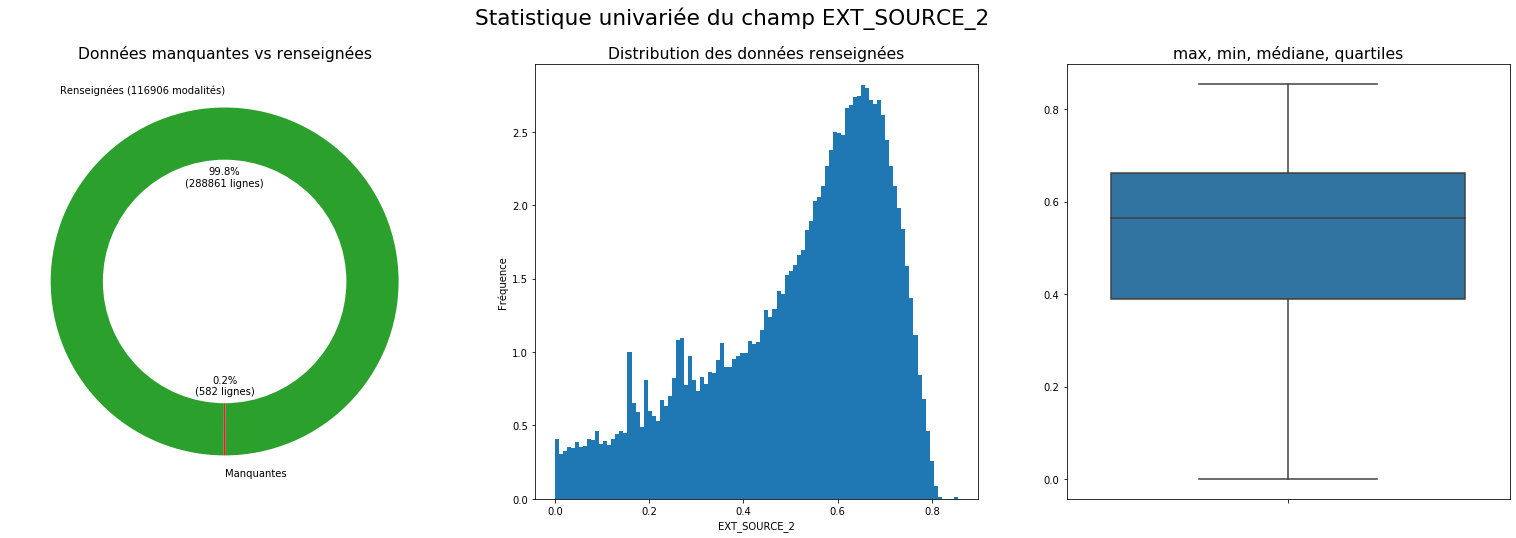

Mesures de position
 - Moyenne: 0.5129
 - Médiane: 0.56445
Mesures de dispertion
 - Ecart type: 0.19128
 - Min: 0.0
 - Q25: 0.39008
 - Q75: 0.66248
 - Max: 0.855
Mesures de forme
 - Skewness (asymétrie): -0.787
 - Kurtosis (applatissement): -0.287


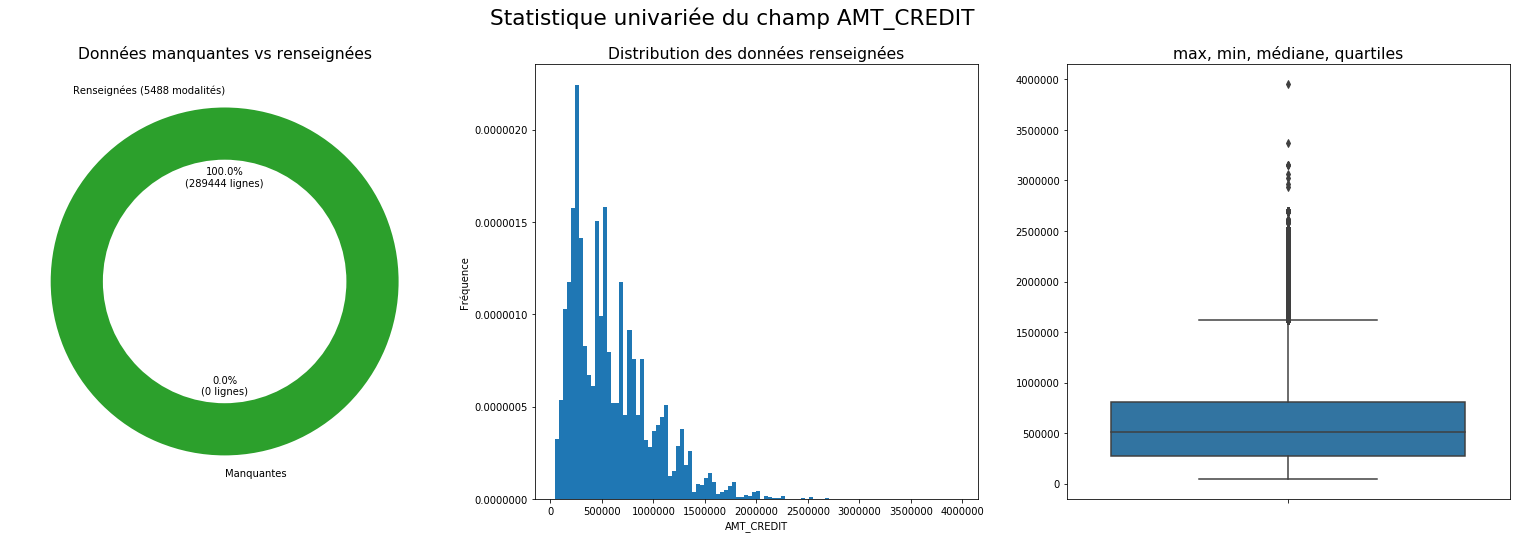

Mesures de position
 - Moyenne: 591114.51013
 - Médiane: 509400.0
Mesures de dispertion
 - Ecart type: 391507.75342
 - Min: 45000.0
 - Q25: 270000.0
 - Q75: 808650.0
 - Max: 3956274.0
Mesures de forme
 - Skewness (asymétrie): 1.135
 - Kurtosis (applatissement): 1.34


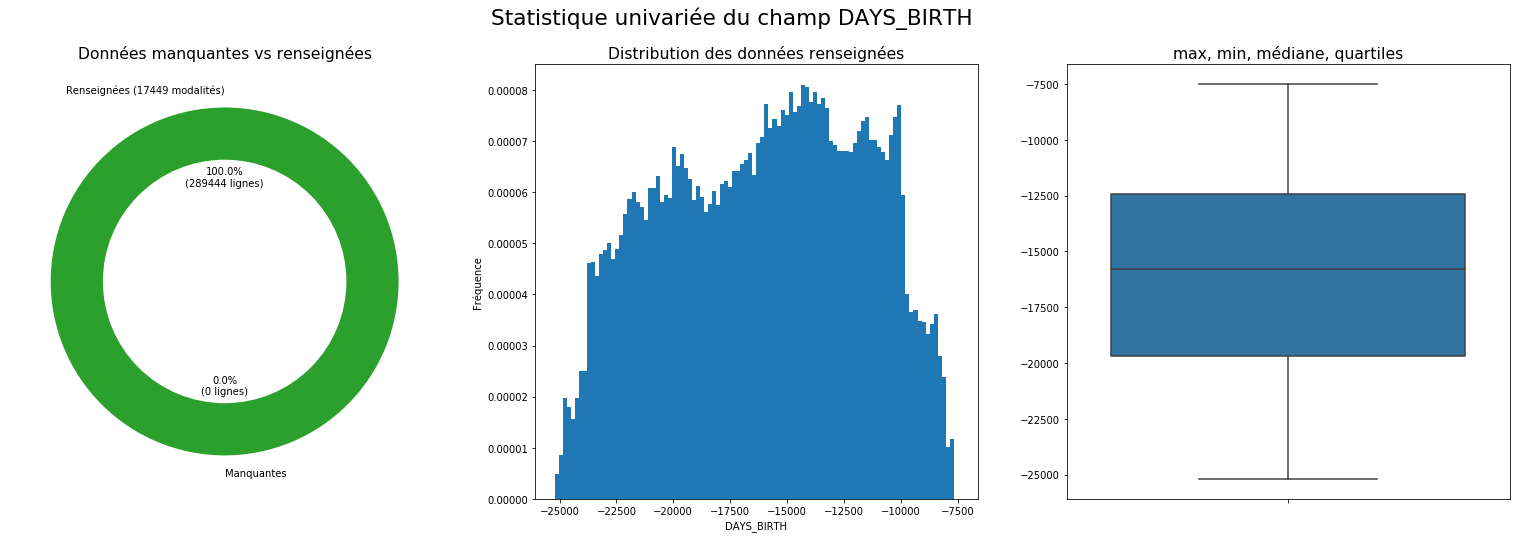

Mesures de position
 - Moyenne: -16058.38581
 - Médiane: -15771.0
Mesures de dispertion
 - Ecart type: 4359.43281
 - Min: -25201
 - Q25: -19698.0
 - Q75: -12447.0
 - Max: -7489
Mesures de forme
 - Skewness (asymétrie): -0.114
 - Kurtosis (applatissement): -1.047


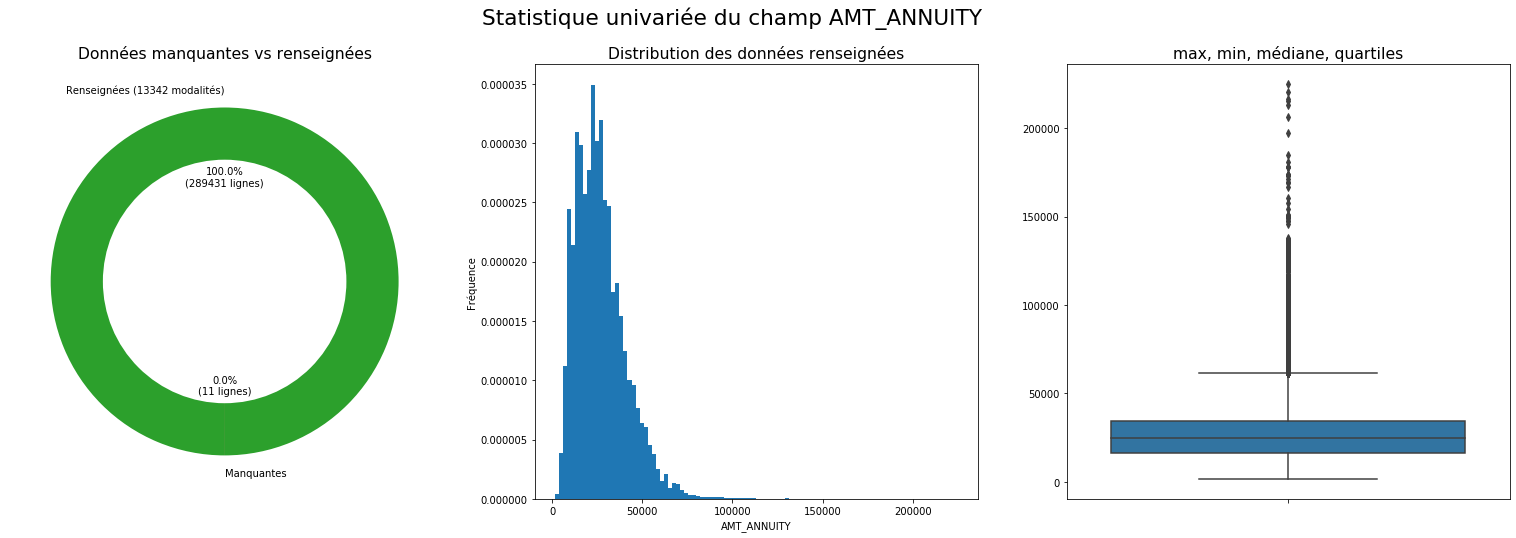

Mesures de position
 - Moyenne: 27004.61959
 - Médiane: 24939.0
Mesures de dispertion
 - Ecart type: 14100.04904
 - Min: 1615.5
 - Q25: 16573.5
 - Q75: 34587.0
 - Max: 225000.0
Mesures de forme
 - Skewness (asymétrie): 1.322
 - Kurtosis (applatissement): 4.464


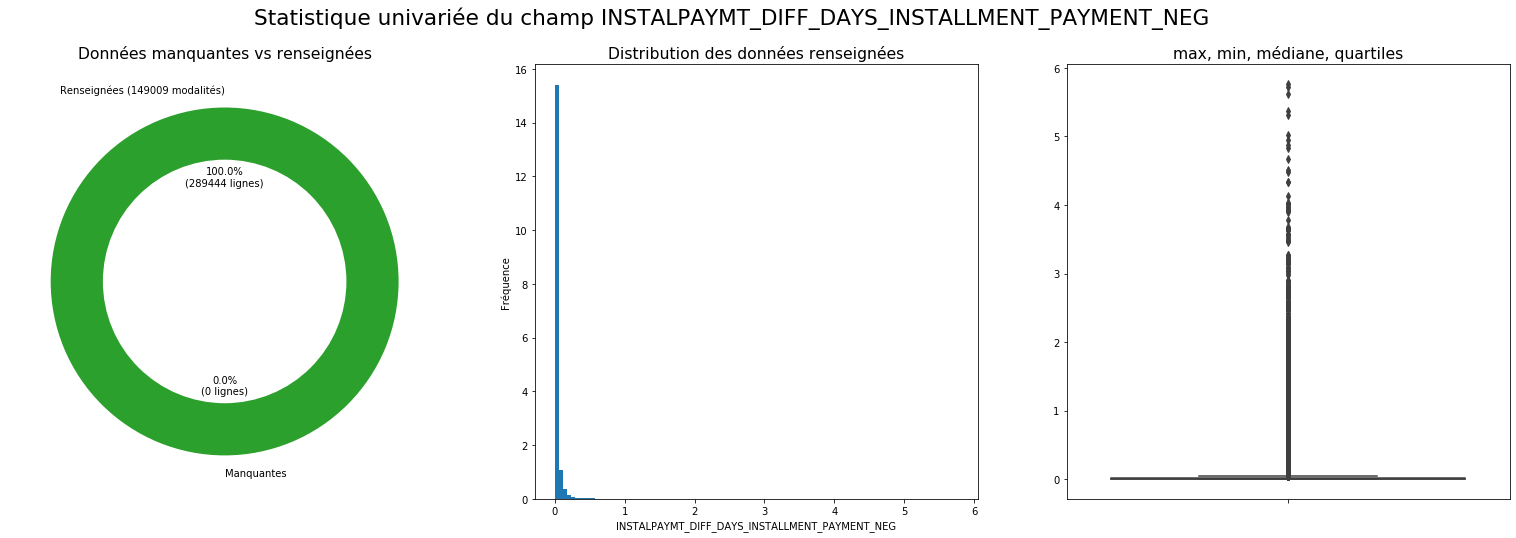

Mesures de position
 - Moyenne: 0.02863
 - Médiane: 0.00146
Mesures de dispertion
 - Ecart type: 0.1175
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.02065
 - Max: 5.76805
Mesures de forme
 - Skewness (asymétrie): 15.97
 - Kurtosis (applatissement): 405.593


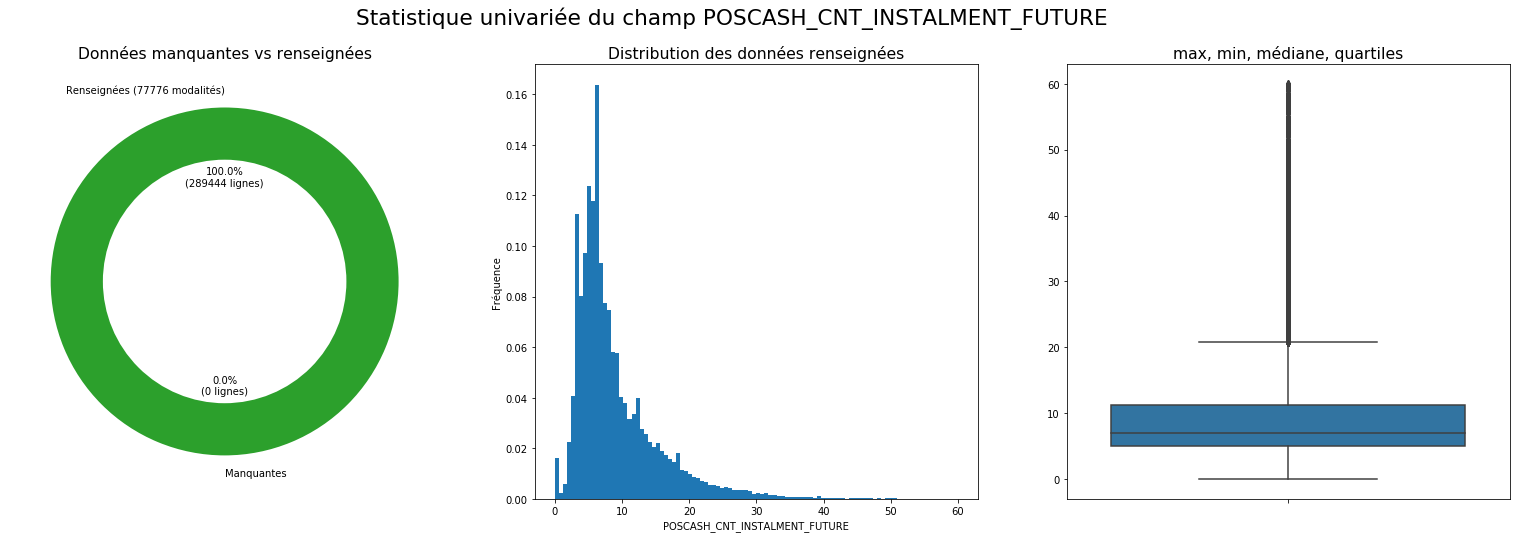

Mesures de position
 - Moyenne: 8.99397
 - Médiane: 6.94349
Mesures de dispertion
 - Ecart type: 6.38984
 - Min: 0.0
 - Q25: 5.0
 - Q75: 11.29432
 - Max: 60.0
Mesures de forme
 - Skewness (asymétrie): 2.042
 - Kurtosis (applatissement): 6.144


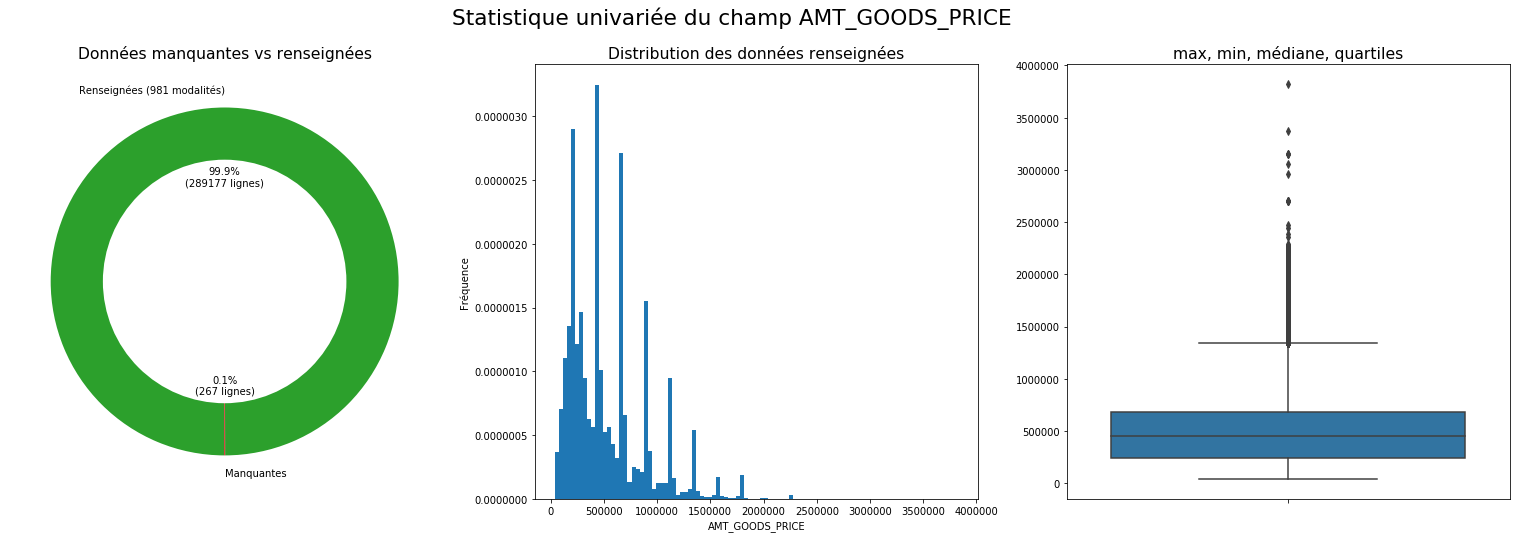

Mesures de position
 - Moyenne: 530724.60452
 - Médiane: 450000.0
Mesures de dispertion
 - Ecart type: 358053.53096
 - Min: 40500.0
 - Q25: 238500.0
 - Q75: 679500.0
 - Max: 3825000.0
Mesures de forme
 - Skewness (asymétrie): 1.234
 - Kurtosis (applatissement): 1.699


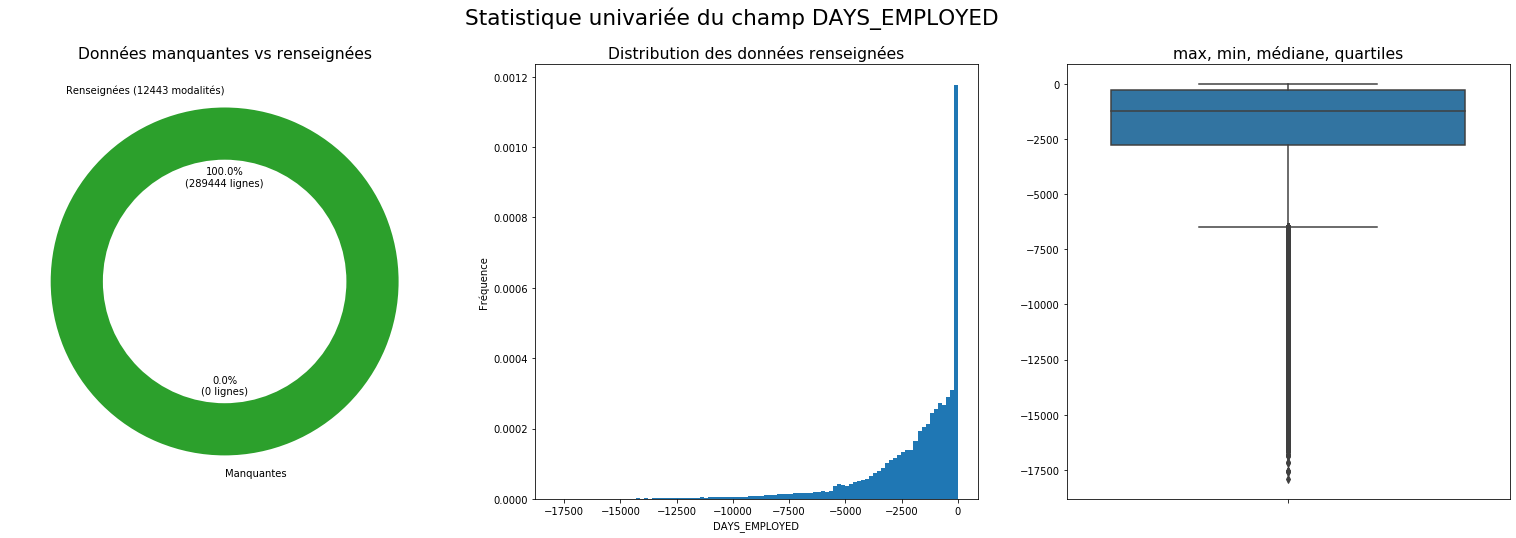

Mesures de position
 - Moyenne: -1966.21941
 - Médiane: -1232.0
Mesures de dispertion
 - Ecart type: 2307.98222
 - Min: -17912
 - Q25: -2777.0
 - Q75: -297.0
 - Max: 0
Mesures de forme
 - Skewness (asymétrie): -2.037
 - Kurtosis (applatissement): 5.193


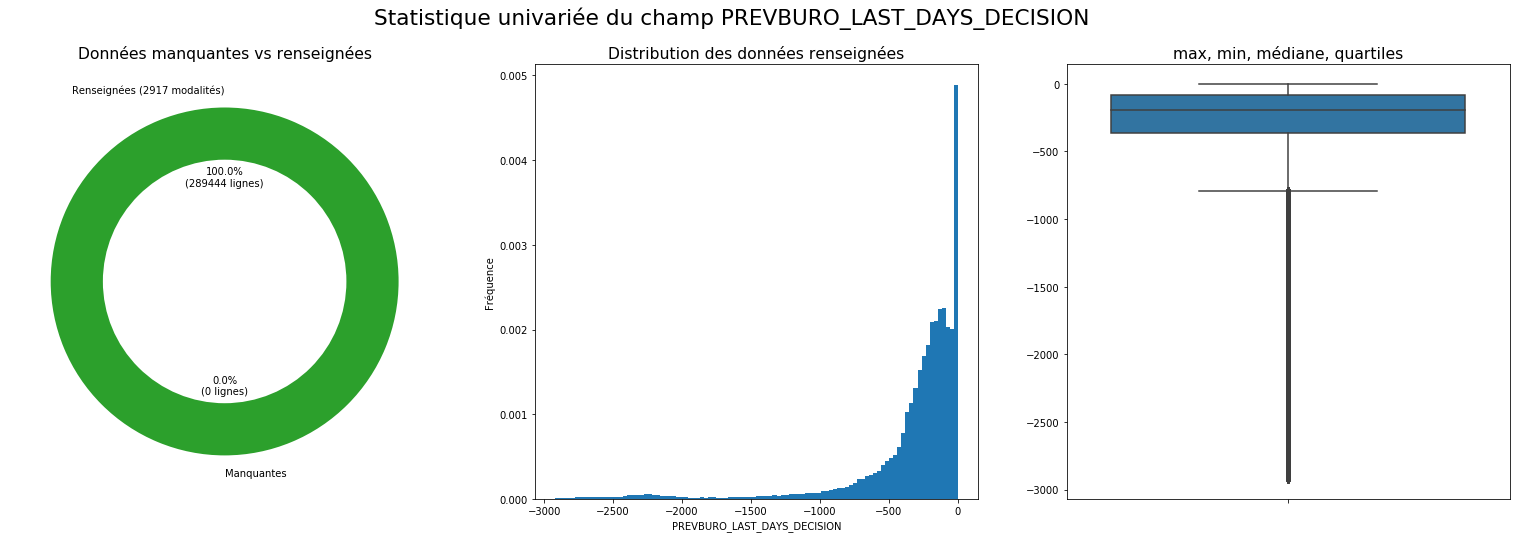

Mesures de position
 - Moyenne: -325.67261
 - Médiane: -197.0
Mesures de dispertion
 - Ecart type: 446.87025
 - Min: -2922.0
 - Q25: -366.0
 - Q75: -83.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -3.15
 - Kurtosis (applatissement): 11.305


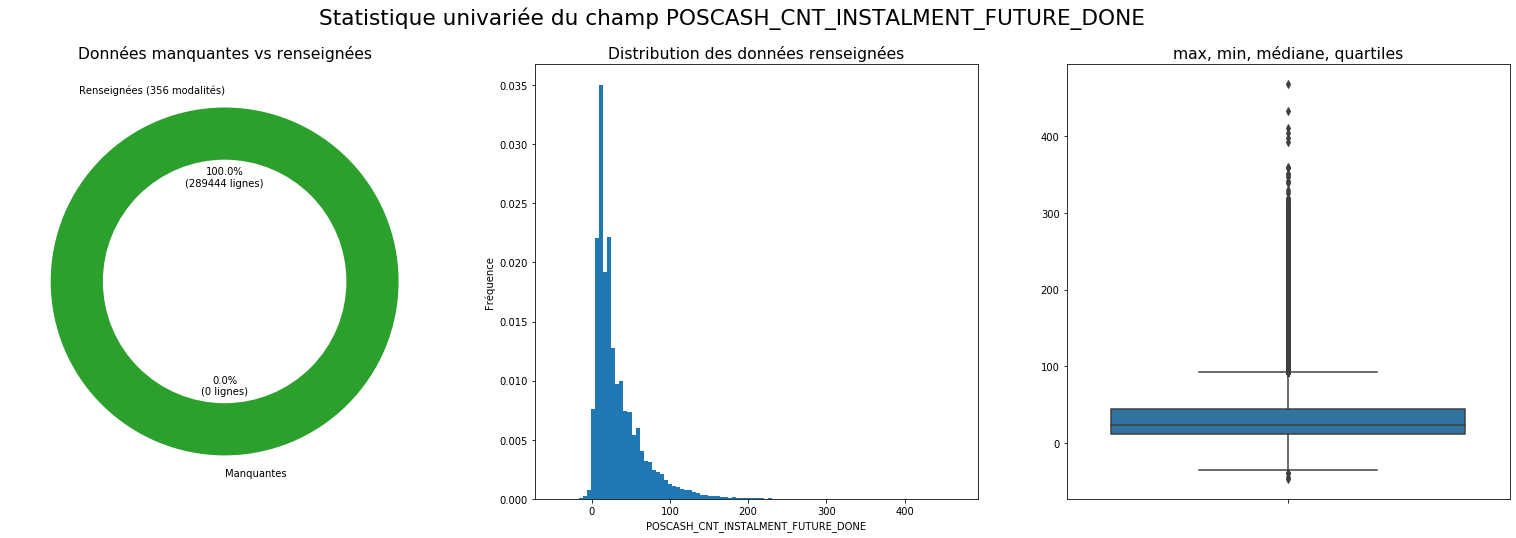

Mesures de position
 - Moyenne: 33.16043
 - Médiane: 23.0
Mesures de dispertion
 - Ecart type: 31.78196
 - Min: -47.0
 - Q25: 12.0
 - Q75: 44.0
 - Max: 468.0
Mesures de forme
 - Skewness (asymétrie): 2.182
 - Kurtosis (applatissement): 7.216


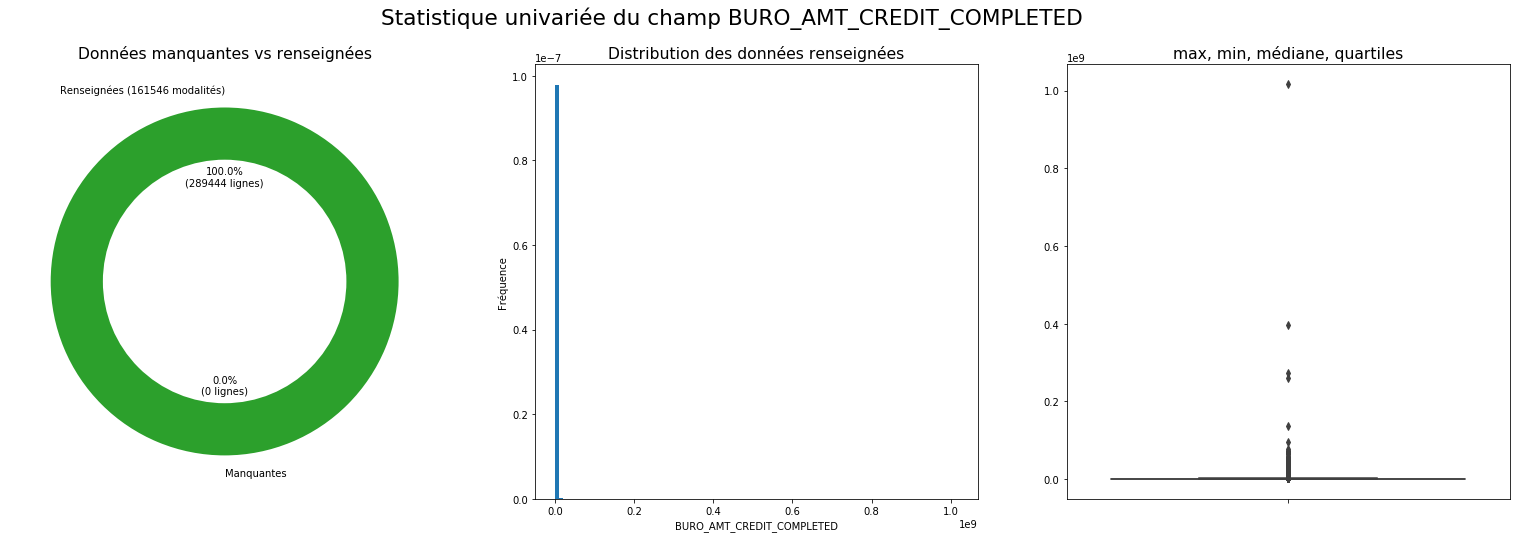

Mesures de position
 - Moyenne: 714360.25375
 - Médiane: 226012.5
Mesures de dispertion
 - Ecart type: 2675664.36658
 - Min: 0.0
 - Q25: 0.0
 - Q75: 763911.495
 - Max: 1017597917.385
Mesures de forme
 - Skewness (asymétrie): 210.252
 - Kurtosis (applatissement): 74449.92


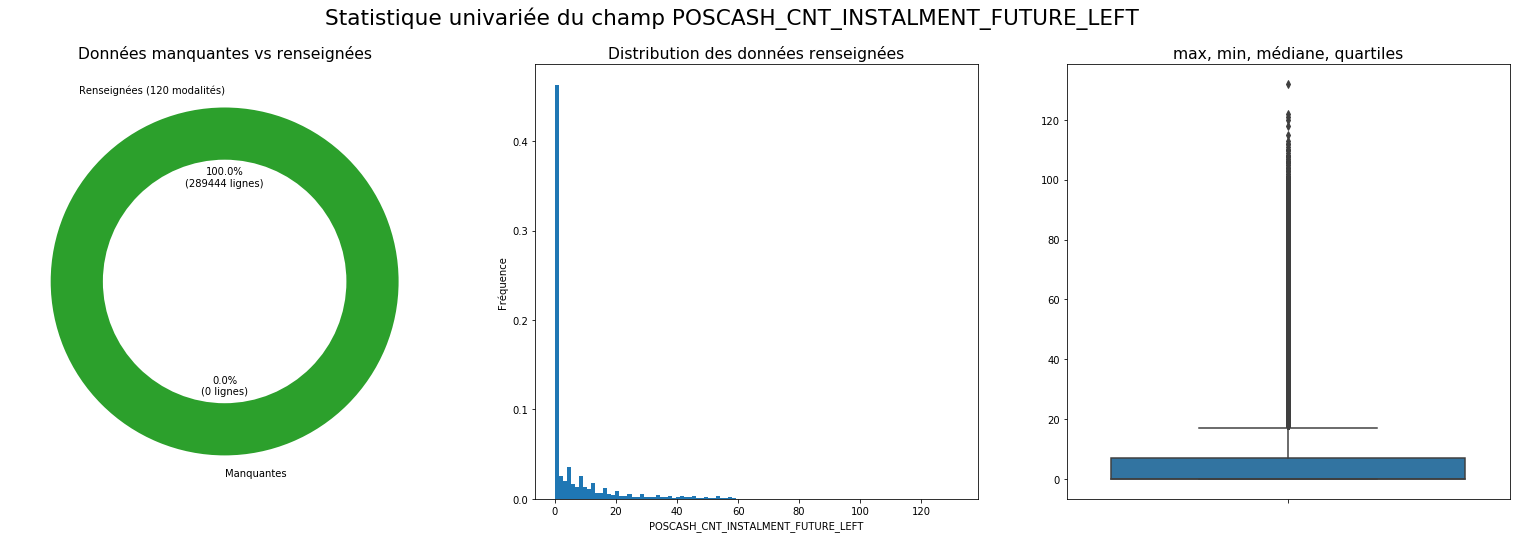

Mesures de position
 - Moyenne: 6.21023
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 11.95548
 - Min: 0.0
 - Q25: 0.0
 - Q75: 7.0
 - Max: 132.0
Mesures de forme
 - Skewness (asymétrie): 2.74
 - Kurtosis (applatissement): 8.462


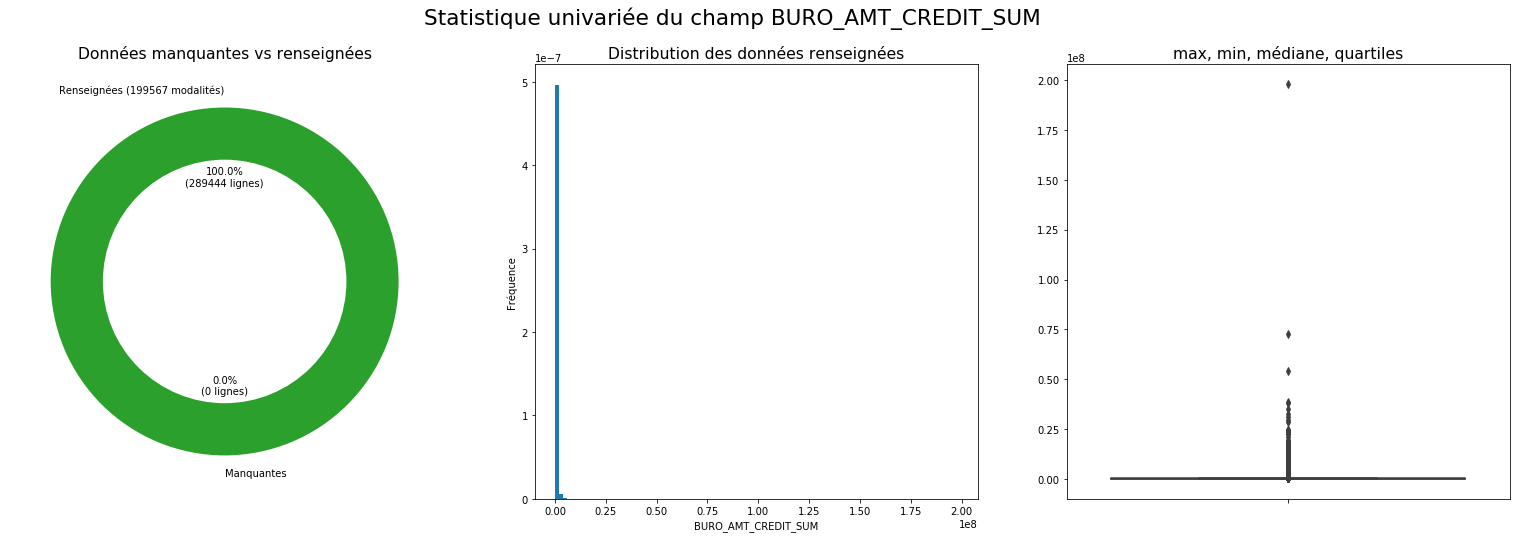

Mesures de position
 - Moyenne: 311031.8569
 - Médiane: 157356.675
Mesures de dispertion
 - Ecart type: 743268.74039
 - Min: 0.0
 - Q25: 66971.10375
 - Q75: 337500.0
 - Max: 198072344.25
Mesures de forme
 - Skewness (asymétrie): 77.312
 - Kurtosis (applatissement): 17912.881


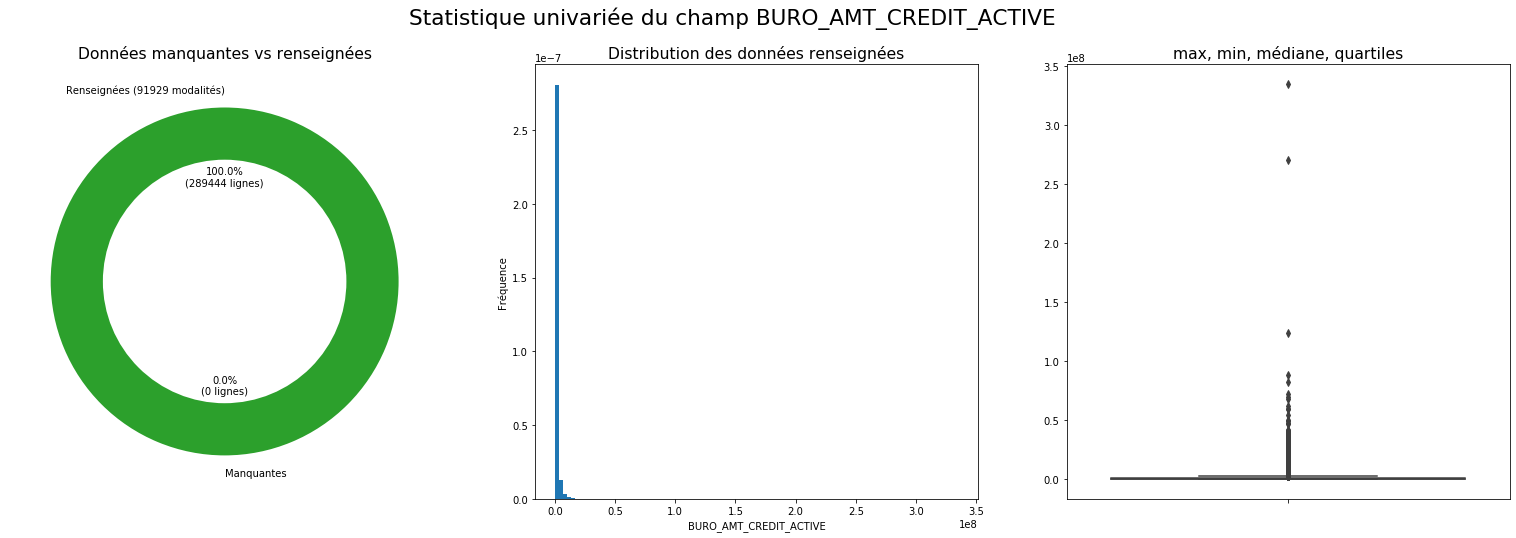

Mesures de position
 - Moyenne: 917516.36063
 - Médiane: 290205.0
Mesures de dispertion
 - Ecart type: 2007687.06902
 - Min: 0.0
 - Q25: 0.0
 - Q75: 1057500.0
 - Max: 334739700.0
Mesures de forme
 - Skewness (asymétrie): 30.171
 - Kurtosis (applatissement): 3884.717


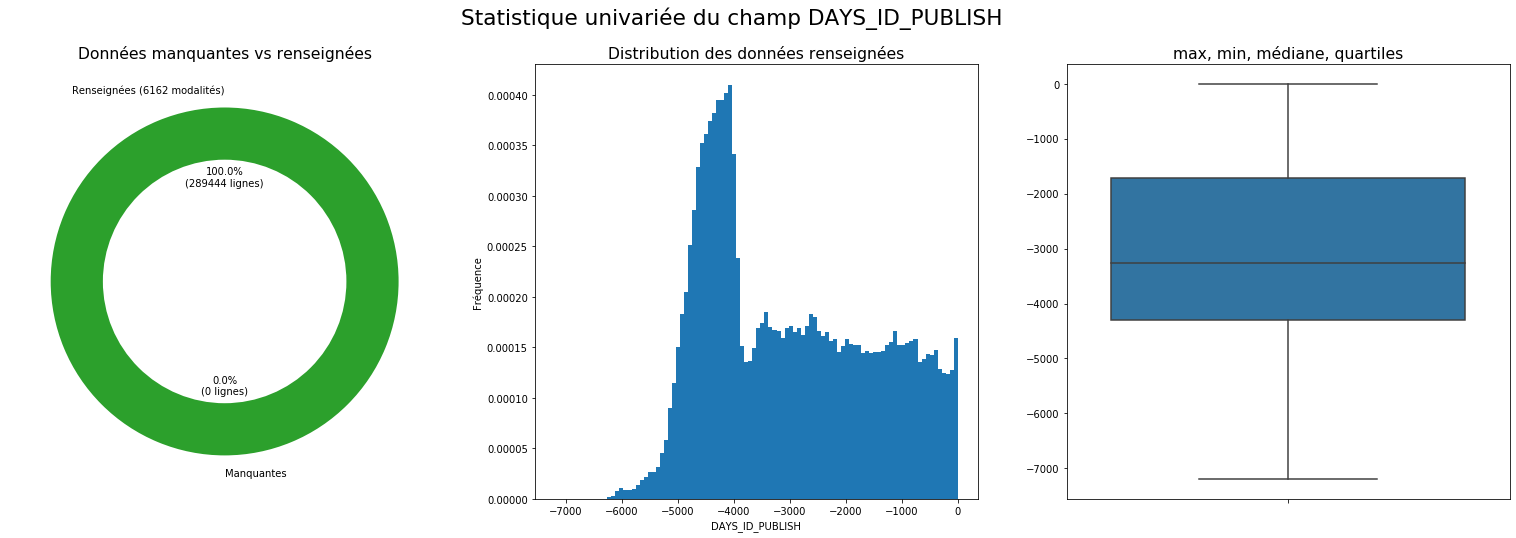

Mesures de position
 - Moyenne: -2995.20292
 - Médiane: -3257.0
Mesures de dispertion
 - Ecart type: 1510.22601
 - Min: -7197
 - Q25: -4299.0
 - Q75: -1719.0
 - Max: 0
Mesures de forme
 - Skewness (asymétrie): 0.351
 - Kurtosis (applatissement): -1.107


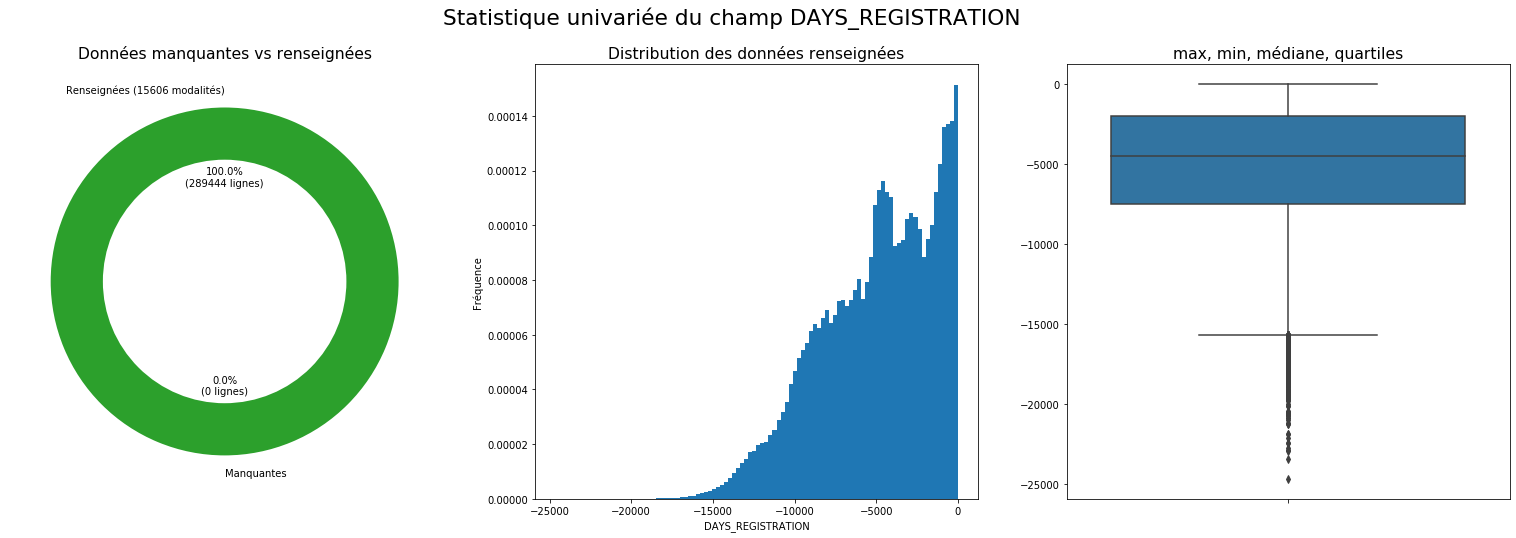

Mesures de position
 - Moyenne: -4997.1553
 - Médiane: -4514.0
Mesures de dispertion
 - Ecart type: 3519.90403
 - Min: -24672.0
 - Q25: -7490.0
 - Q75: -2032.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.589
 - Kurtosis (applatissement): -0.324


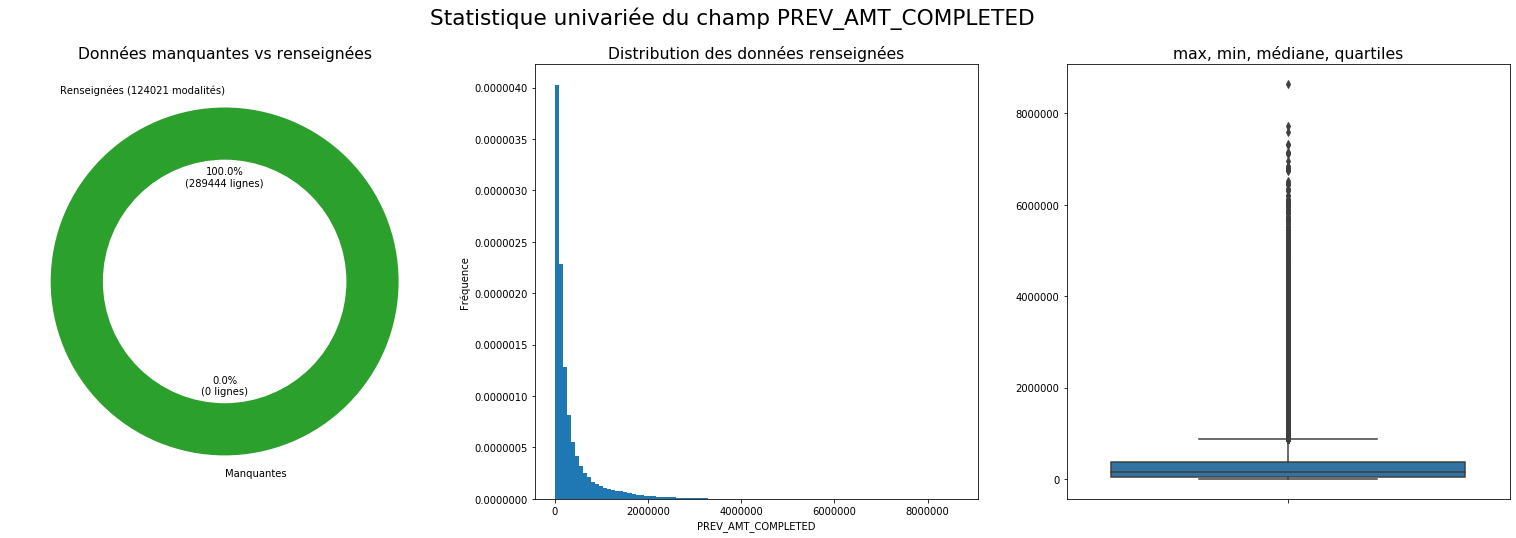

Mesures de position
 - Moyenne: 336944.84504
 - Médiane: 148441.5
Mesures de dispertion
 - Ecart type: 515002.87746
 - Min: 0.0
 - Q25: 53235.0
 - Q75: 383148.0
 - Max: 8647992.0
Mesures de forme
 - Skewness (asymétrie): 3.347
 - Kurtosis (applatissement): 16.334


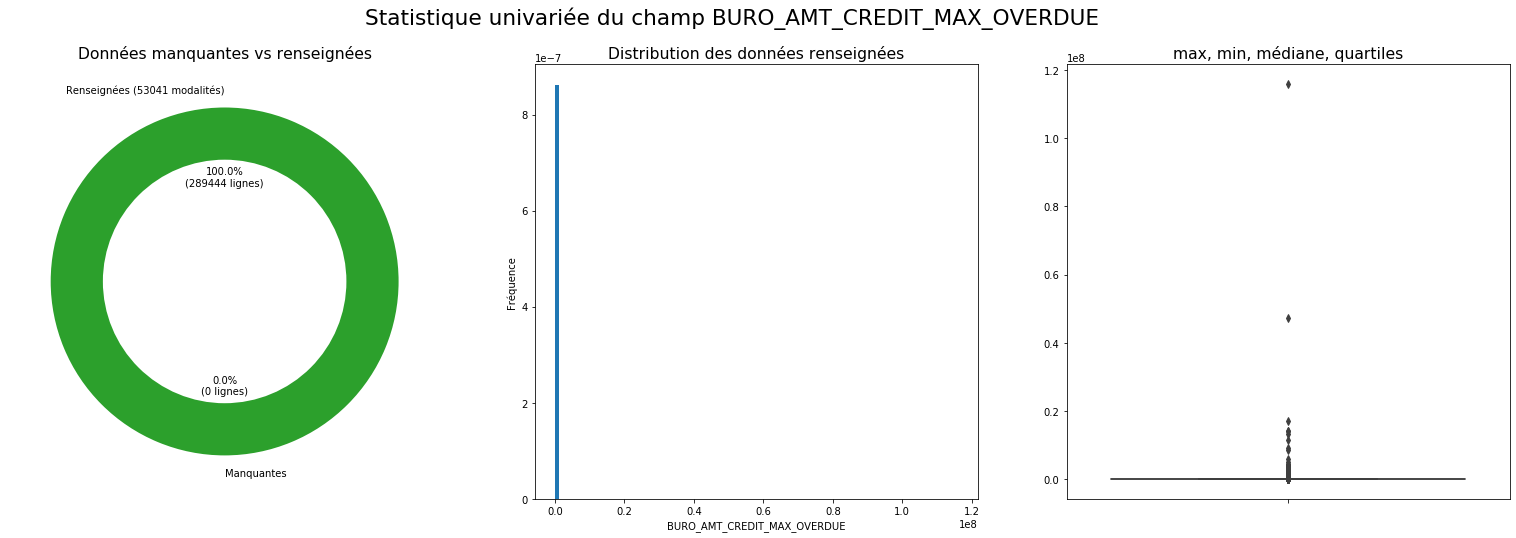

Mesures de position
 - Moyenne: 3151.98777
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 243719.36231
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 115987185.0
Mesures de forme
 - Skewness (asymétrie): 401.744
 - Kurtosis (applatissement): 182362.438


In [72]:
i = 1
for col in imp.feature:
    if i <= 20:
        myDf(dfApplication).Stat(col, statsNan=True)
    i += 1

### Création pour le dashboard des seuils de score avec pourcentage de dèfaut

Pourcentage de personnes à risque en fonction du seuil

In [73]:
del dfApplication['TARGET']
del dfApplication['SK_ID_CURR']

pred = pipeline.predict_proba(dfApplication)
pred = pred.T[1]

prct_default_seuil = []
seuil = np.arange(1000) /1000
for s in seuil:
    prct_default_seuil.append(0.0+len([p for p in pred if p > s]) / pred.shape[0])


seuil_stat = pd.DataFrame({'seuil':seuil,'prct_default_seuil':prct_default_seuil})

Text(0.5, 1.0, 'Pourcentage de personne à risque en fonction du seuil')

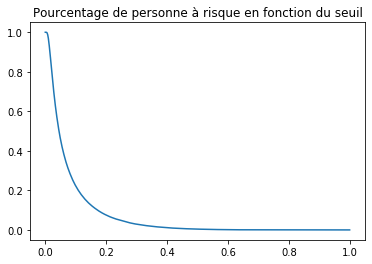

In [74]:
plt.plot(seuil, prct_default_seuil)
plt.title('Pourcentage de personne à risque en fonction du seuil')

### Sauvegardes pour le dashboard

#### Les variables et leur importance à conserver pour la prédiction et le dashboard

In [75]:
dump(imp, open('feature_importance.pkl','wb'))

#### Le pipeline

In [76]:
#https://stackoverflow.com/questions/46077793/how-to-save-a-custom-transformer-in-sklearn
#dump(pipeline, open('pipeline.pkl','wb'))
joblib.dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

#### Les pourcentage de personnes à risque en fonction du seuil

In [77]:
dump(list(seuil_stat.columns), open('seuil_stat_col.pkl','wb'))
dump(list(seuil_stat.values), open('seuil_stat_value.pkl','wb'))

#### Les ratios de target positive selon les valeurs des variables

In [78]:
dump(listRatioCat, open('RatioCat.pkl','wb'))
dump(listRatioOrd, open('RatioOrd.pkl','wb'))
dump(list(distribRatioNum.columns), open('RatioNum_col.pkl','wb'))
dump(list(distribRatioNum.values), open('RatioNum_value.pkl','wb'))